# Mega Case Study - Hybrid Deep Learning Model (ANN & SOM)

#### Goal: Identify the outliers that are potential fraudulent customers, then using those customers as truth train an ANN that uses all features, except id, to identify the probabilities of that customer being fraudulent.

## Part 1 - Identify the Frauds with the Self-Organizing Map

### Importing the Libraries

In [31]:
import numpy as np
import matplotlib as plt
import pandas as pd
from minisom import MiniSom

### Load the Dataset

In [32]:
dataset = pd.read_csv('data/som_ann/Credit_Card_Applications.csv')
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

### Feature Scaling

In [33]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
X_scaled = sc.fit_transform(X)

### Training the SOM

In [34]:
som = MiniSom(x=10, y=10, input_len = 15, sigma = 1.0, learning_rate=0.5)

# Initialize the weights
som.random_weights_init(X_scaled)

# Repeat steps 4 -> 9 on training guide
som.train_random(data = X_scaled, num_iteration = 100)

### Visualize the Results

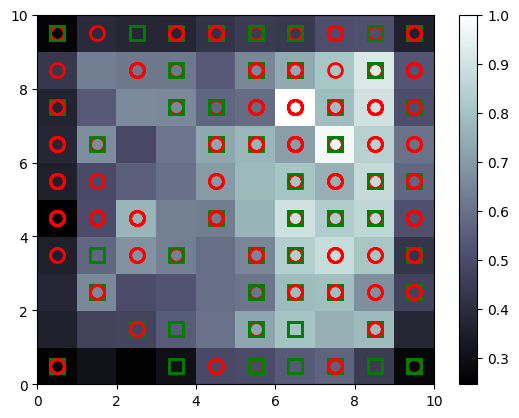

In [35]:
# MID = Mean Internodal Distance
from pylab import bone, pcolor, colorbar, plot, show

# initialize the figure
bone()

# colors are the distances
# som.distance_map() returns the mean interneuron distances as a matrix (array of arrays)
pcolor(som.distance_map().T) # transpose for right order for p value method

# legend (normalized)
colorbar() # whites are outliers and potential frauds

# Lets make this clearer
markers = ['o', 's'] # circle and square
colors = ['r', 'g'] 

# loop over each customer 
# red if not approved, green if approved

for i, x in enumerate(X_scaled): # i is index, x is the vector of that customer
    w = som.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5, # put at center of winning node inside the square
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2) # make it a circle or square and red or green based on the actual output




### Identify the Fraud

In [36]:
mappings = som.win_map(X_scaled)
frauds = np.concatenate((mappings[(6,7)], mappings[(7,6)]), axis = 0)
frauds_final = sc.inverse_transform(frauds) # Inverse the scaling
pd.DataFrame(frauds_final) # Column 0 will be the customer Ids that potentially frauded the system

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,15594305.0,0.0,23.75,0.710,2.0,9.0,4.0,0.250,0.0,1.0,1.0,1.0,2.0,240.0,5.0
1,15664793.0,0.0,17.33,9.500,2.0,6.0,4.0,1.750,0.0,1.0,10.0,1.0,2.0,0.0,11.0
2,15670029.0,0.0,16.92,0.500,2.0,3.0,4.0,0.165,0.0,1.0,6.0,1.0,2.0,240.0,36.0
3,15763579.0,0.0,16.00,0.165,2.0,6.0,4.0,1.000,0.0,1.0,2.0,1.0,2.0,320.0,2.0
4,15662189.0,0.0,28.58,3.750,2.0,8.0,4.0,0.250,0.0,1.0,1.0,1.0,2.0,40.0,155.0
5,15568469.0,0.0,15.83,7.625,2.0,11.0,4.0,0.125,0.0,1.0,1.0,1.0,2.0,0.0,161.0
6,15782159.0,0.0,22.67,0.750,2.0,8.0,4.0,2.000,0.0,1.0,2.0,1.0,2.0,200.0,395.0
7,15586479.0,0.0,27.25,0.290,2.0,7.0,8.0,0.125,0.0,1.0,1.0,1.0,2.0,272.0,109.0
8,15717700.0,0.0,23.58,0.830,2.0,11.0,4.0,0.415,0.0,1.0,1.0,1.0,2.0,200.0,12.0
9,15705379.0,0.0,30.58,10.665,2.0,11.0,8.0,0.085,0.0,1.0,12.0,1.0,2.0,129.0,4.0


## Part 2 - Going from Unsupervised to Supervised Deep Learning

### Creating the Matrix of Features

In [40]:
customers = dataset.iloc[:, 1:].values # This time just removing the customer Id since credit approval or denial could help

### Create the dependent variable

In [42]:
is_fraud = np.zeros(len(dataset)) # initialize a vector

In [43]:
# set is_fraud to true for all ids inside final_frauds from SOM

for i in range(len(dataset)):
    if dataset.iloc[i, 0] in frauds_final:
        is_fraud[i] = 1

### Train the ANN

#### Feature Scaling

In [46]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customers = sc.fit_transform(customers)

#### Import the Packaages

In [51]:
from keras.models import Sequential
from keras.layers import Dense

#### Build the ANN

In [55]:
classifier = Sequential()

In [57]:
classifier.add(Dense(units = 2, kernel_initializer='uniform', activation='relu', input_dim=15)) # input_dim is the number of features

/home/fraher/code/deepnn/.env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1738094856.837809   37273 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6096 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5


In [58]:
classifier.add(Dense(units = 1, kernel_initializer='uniform', activation='sigmoid')) # input_dim is the number of features

In [59]:
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [61]:
classifier.fit(customers, is_fraud, batch_size=1, epochs=2)

Epoch 1/2
690/690 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9840 - loss: 0.1603
Epoch 2/2
690/690 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9788 - loss: 0.0911


### Predicting the probabilities of frauds

In [86]:
y_pred = classifier.predict(customers)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


#### Clean up and sort

In [88]:
y_pred = np.concatenate((dataset.iloc[:,0:1].values, y_pred), axis=1)

In [89]:
y_pred = y_pred[y_pred[:, 1].argsort()[::-1]] # Sort by index 1

In [92]:
df = pd.DataFrame(y_pred, columns=["Customer ID", "Probability Fraud"])
df["Probability Fraud"] = (df["Probability Fraud"] * 100).map("{:.2f}%".format)

In [100]:
df

,Customer ID,Probability Fraud
0,15664793.0,26.25%
1,15608595.0,21.77%
2,15815271.0,18.26%
3,15705379.0,17.00%
4,15586479.0,16.89%
...,...,...
685,15585855.0,0.22%
686,15725028.0,0.18%
687,15654859.0,0.13%
688,15621423.0,0.10%
